In [1]:
# set cuda visible devices to 0
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# TOKENIZERS_PARALLELISM
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [2]:
import pandas as pd
from text_metrics.surprisal_extractors.extractors_constants import SurpExtractorType
from text_metrics.surprisal_extractors.extractor_switch import (
    get_surp_extractor,
)
from typing import List

In [3]:
et_data = pd.read_csv(
    "/data/home/shared/onestop/processed/ia_data_enriched_360_05052024.csv",
    engine="pyarrow",
)

In [4]:
unique_texts_et_data = (
    et_data.query("reread == 0")
    .groupby(["subject_id", "unique_paragraph_id"])
    .agg(
        {
            "IA_ID": tuple,
            "IA_LABEL": tuple,
            "is_before_aspan": tuple,
            "is_in_aspan": tuple,
            "is_after_aspan": tuple,
            "question": "first",
        }
    )
)

unique_texts_et_data_q_aggregated = (
    unique_texts_et_data.groupby(
        ["IA_ID", "IA_LABEL", "is_in_aspan", "is_before_aspan", "is_after_aspan"]
    )
    .aggregate({"question": list})
    .reset_index()
)

unique_texts_et_data_q_aggregated["question"] = unique_texts_et_data_q_aggregated[
    "question"
].apply(lambda x: tuple(set(x)))

unique_texts_et_data = unique_texts_et_data_q_aggregated


In [62]:
from text_metrics.ling_metrics_funcs import get_metrics
from functools import partial
import numpy as np

model_name = "EleutherAI/pythia-6.9b"
surp_extractor = get_surp_extractor(
    extractor_type=SurpExtractorType.CAT_CTX_LEFT, model_name=model_name
)

/data/home/meiri.yoav/miniforge3/envs/osg-cuda/lib/python3.12/site-packages/huggingface_hub-0.25.0-py3.8.egg/huggingface_hub/file_download.py:1142: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [63]:
def calc_surp_ratios(
    text_lst: List[str],
    surp_extractor: SurpExtractorType,
    left_ctx: str,
    model_name: str,
):
    text = " ".join(text_lst)
    get_metrics_partial = partial(
        get_metrics,
        target_text=text,
        surp_extractor=surp_extractor,
        parsing_model=None,
        parsing_mode=None,
        add_parsing_features=False,
        overlap_size=512,
    )
    # prompt = "You will now be given a question about a paragraph followed by the paragraph. You will need to answer the question."
    surp_with_question = get_metrics_partial(
        # left_context_text=prompt + " " + left_ctx,
        left_context_text=left_ctx
    )[f"{model_name}_Surprisal"]

    surp_without_question = get_metrics_partial(
        left_context_text=None,
    )[f"{model_name}_Surprisal"]

    surp_ratio = (surp_with_question / surp_without_question).values.tolist()

    return surp_ratio


def agg_surp_ratio_relative_to_aspan(
    row,
    surp_extractor: SurpExtractorType,
    model_name: str,
):
    """
    Aggregates surprisal ratios relative to a span (aspan), for different
    sections of the text (in, before, and after the span).

    Args:
        row (dict): A row of data containing text labels, question, and masks for aspan.
        surp_extractor (SurpExtractorType): Function to extract surprisal values.
        model_name (str): Name of the model used to calculate surprisal.

    Returns:
        list of tuples: Each tuple contains the aggregated surprisal ratios for:
            (in_aspan, before_aspan, after_aspan), or NaN if no valid data exists.
    """

    def compute_masked_surp_ratio(surp_ratios, mask):
        """Helper function to calculate the sum-to-count ratio for a masked region."""
        masked_ratios = np.array(
            [surp_ratios[i] for i in range(len(surp_ratios)) if mask[i]]
        )
        if len(masked_ratios) == 0 or np.sum(masked_ratios > 0) == 0:
            return np.nan
        return masked_ratios.sum() / np.sum(masked_ratios > 0)

    # Extract text list and the relevant masks, skipping the first token
    text_lst = row["IA_LABEL"]
    is_in_aspan_mask = row["is_in_aspan"][1:]
    is_before_aspan_mask = row["is_before_aspan"][1:]
    is_after_aspan_mask = row["is_after_aspan"][1:]

    # List to store the result ratios for each question
    ratios_lst = []

    for question in row["question"]:
        # Calculate surprisal ratios, excluding the first token
        surp_ratios = calc_surp_ratios(
            text_lst=text_lst,
            surp_extractor=surp_extractor,
            left_ctx=question,
            model_name=model_name,
        )[1:]

        # Compute ratios for each section (in, before, after aspan)
        in_aspan_ratio = compute_masked_surp_ratio(surp_ratios, is_in_aspan_mask)
        before_aspan_ratio = compute_masked_surp_ratio(
            surp_ratios, is_before_aspan_mask
        )
        after_aspan_ratio = compute_masked_surp_ratio(surp_ratios, is_after_aspan_mask)

        # Append the ratios as a tuple
        ratios_lst.append([before_aspan_ratio, in_aspan_ratio, after_aspan_ratio])

    return ratios_lst, surp_ratios

In [64]:
res = unique_texts_et_data.apply(
    agg_surp_ratio_relative_to_aspan,
    surp_extractor=surp_extractor,
    model_name=model_name,
    axis=1,
)

In [73]:
relative_to_aspan_ratios = res.apply(lambda x: x[0])
all_surp_ratios = res.apply(lambda x: x[1])

In [74]:
all_surp_ratios

0      [0.9031354208136108, 2.968087897542708, 0.7617...
1      [0.3535309254779142, 0.24933776053162376, 0.41...
2      [1.3083045853295165, 1.1844855210748033, 1.235...
3      [1.1500196473709259, 0.8208378847634872, 1.681...
4      [0.8817430045013176, 0.5495227858359591, 1.906...
                             ...                        
784    [1.4377928752254223, 1.0750544288419013, 0.986...
785    [1.3868248078321757, 0.900865359032403, 0.6133...
786    [1.742989070674597, 0.9897245448260606, 1.0325...
787    [1.6398435509116909, 0.8943175058353453, 0.292...
788    [1.1561278868678386, 0.3041997466096087, 0.028...
Length: 789, dtype: object

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

normalize_locations = True
all_surp_ratios_w_relative_position = all_surp_ratios.apply(
    lambda x: list(
        zip(
            [(i + 1) / len(x) if normalize_locations else i + 1 for i in range(len(x))],
            x,
        )
    )
)

all_surp_ratios_w_relative_position = all_surp_ratios_w_relative_position.sum()

# make this a pandas dataframe
all_surp_ratios_w_relative_position = pd.DataFrame(
    all_surp_ratios_w_relative_position, columns=["relative_position", "surp_ratio"]
)
# all_surp_ratios_w_relative_position = (
#     all_surp_ratios_w_relative_position.groupby("relative_position")
#     .agg({"surp_ratio": "mean"})
#     .reset_index()
# )

# all_surp_ratios_w_relative_position = all_surp_ratios_w_relative_position.query(
#     "relative_position <= 150 and relative_position >= 2"
# )

In [76]:
all_surp_ratios_w_relative_position


,relative_position,surp_ratio
0,0.020408,0.903135
1,0.040816,2.968088
2,0.061224,0.761754
3,0.081633,0.787142
4,0.102041,1.710133
...,...,...
85479,0.975610,0.821463
85480,0.981707,1.007759
85481,0.987805,1.032800
85482,0.993902,1.008058


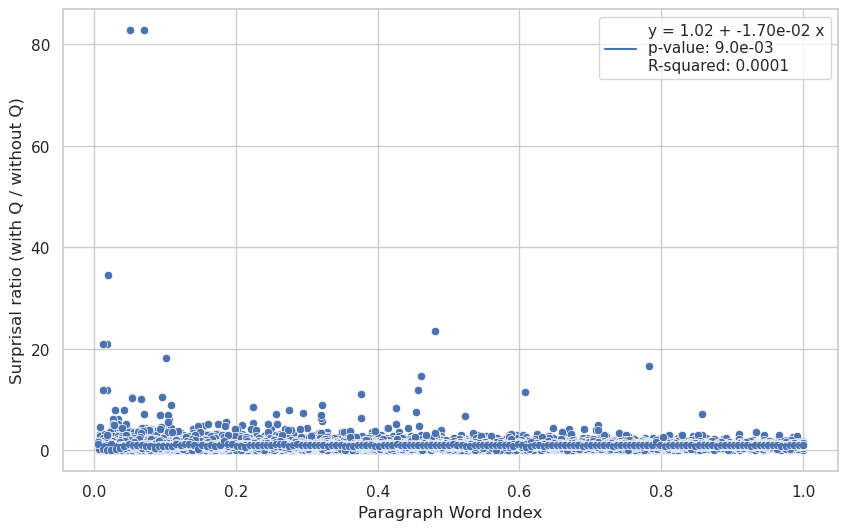

In [77]:
# now create a line plot of the surprisal ratios as a function of the relative position
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="relative_position",
    y="surp_ratio",
    data=all_surp_ratios_w_relative_position,
)

# fi ta linear regresion line using statsmodels, add the line, p value and r squared to the plot

X = all_surp_ratios_w_relative_position["relative_position"].values
X = sm.add_constant(X)
y = all_surp_ratios_w_relative_position["surp_ratio"].values
model = sm.OLS(y, X)
results = model.fit()

plt.plot(
    all_surp_ratios_w_relative_position["relative_position"].values,
    results.predict(X),
    label=f"""y = {results.params[0]:.2f} + {results.params[1]:.2e} x\np-value: {results.pvalues[1]:.1e}\nR-squared: {results.rsquared:.4f}""",
)

plt.xlabel("Paragraph Word Index")
plt.ylabel("Surprisal ratio (with Q / without Q)")
# plt.title("Surprisal ratio as a function of the relative position")
plt.legend()
plt.show()

In [78]:
flat_res = [x for xs in relative_to_aspan_ratios.tolist() for x in xs]
flat_res = np.array(flat_res)

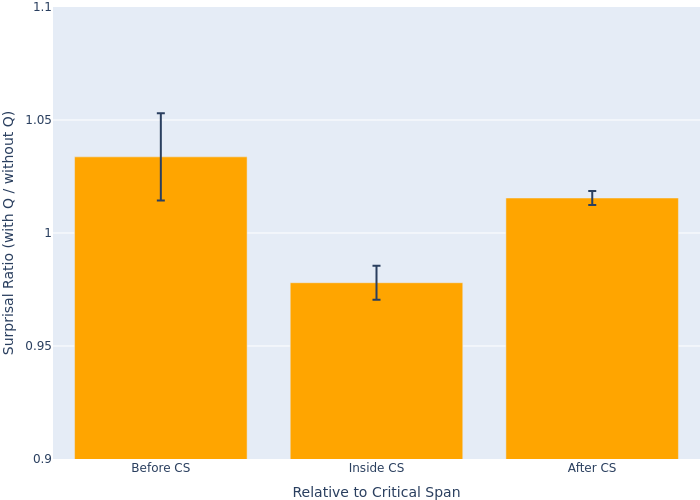

In [81]:
import numpy as np
import plotly.graph_objects as go

# Calculating mean and standard error for each column, ignoring NaNs
means = np.nanmean(flat_res, axis=0)
std_errors = np.nanstd(flat_res, axis=0) / np.sqrt(np.sum(~np.isnan(flat_res), axis=0))

# Bar labels
bar_names = ["Before CS", "Inside CS", "After CS"]
conf_intervals = 1.96 * std_errors

# Creating the bar plot
fig = go.Figure()

# Add bars with error bars (confidence intervals)
color = "orange"
fig.add_trace(
    go.Bar(
        x=bar_names,
        y=means,
        error_y=dict(type="data", array=conf_intervals, visible=True),
        marker_color=[color, color, color],  # Optional: change bar colors
    )
)

# Add layout details
fig.update_layout(
    # title="Confidence Intervals for Before CS, Inside CS, and After CS",
    xaxis_title="Relative to Critical Span",
    yaxis_title="Surprisal Ratio (with Q / without Q)",
    yaxis=dict(range=[0.9, 1.1]),  # Optional: change y-axis range
    # margin
    margin=dict(l=0, r=0, t=0, b=0),
)

# Show plot
fig.show(renderer="png")
# export the plot
# fig.write_image("surprisal_ratios.svg")


In [80]:
# do a t test to see if the surprisal ratios are significantly different (all pairs of before, in, after)
from scipy.stats import ttest_ind

print("T-test results:")
print("Before CS vs Inside CS:")
print(
    f"{ttest_ind(flat_res[:, 0], flat_res[:, 1], nan_policy='omit', alternative="two-sided").pvalue:.2e}"
)
print("Inside CS vs After CS:")
print(
    f"{ttest_ind(flat_res[:, 1], flat_res[:, 2], nan_policy='omit', alternative="two-sided").pvalue:.2e}"
)
print("Before CS vs After CS:")
print(
    f"{ttest_ind(flat_res[:, 0], flat_res[:, 2], nan_policy='omit', alternative="two-sided").pvalue:.2e}"
)


T-test results:
Before CS vs Inside CS:
1.87e-08
Inside CS vs After CS:
4.57e-15
Before CS vs After CS:
8.86e-02
